In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

import h5py
import numpy as np

sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/fcstpp/')

import data_utils as du
import graph_utils as gu
from fcstpp import utils as fu

from namelist import * 

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# Data

In [5]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

In [6]:
with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]

## Datetime info

In [7]:
mon_rain = np.array([9, 10, 11, 0, 1, 2])
mon_dry = np.array([3, 4, 5, 6, 7, 8])

base = datetime(2017, 1, 1)
date_list = [base + timedelta(days=x) for x in range(365+365+365)]

rain_inds = np.zeros((len(date_list),), dtype=bool)
dry_inds = np.zeros((len(date_list),), dtype=bool)

mon_inds = []
for d, date in enumerate(date_list):
    
    mon_inds.append(date.month-1)
    if date.month-1 in mon_dry:
        dry_inds[d] = True
    else:
        rain_inds[d] = True
        
mon_inds = np.array(mon_inds)

fcst_leads = np.arange(3, 72*3+3, 3, dtype=np.float)

## CRPS results

In [8]:
from scipy.stats import wilcoxon

def wilcoxon_by_leads(FCST1, FCST2):
    N, L = FCST1.shape
    w_stat = np.empty((L,))
    p_vals = np.empty((L,))
    
    series1 = FCST1
    series2 = FCST2
    
    for i in range(L):
        w_, p_ = wilcoxon(series1[:, i], series2[:, i],)
        w_stat[i] = w_
        p_vals[i] = p_
    return w_stat, p_vals

def boost_mean_std(data):
    temp = fu.score_bootstrap_1d(data, bootstrap_n=100)
    mean_ = np.mean(temp, axis=-1)
    p95_ = np.quantile(temp-mean_[..., None], 0.95, axis=-1)
    return mean_, p95_

In [9]:
# with h5py.File(save_dir+'CLIM_CRPS_BCH_2017.hdf', 'r') as h5io:
#     CLIM_CRPS_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'CLIM_CRPS_BCH_2018.hdf', 'r') as h5io:
#     CLIM_CRPS_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'CLIM_CRPS_BCH_2019.hdf', 'r') as h5io:
#     CLIM_CRPS_19 = h5io['CRPS'][...]

# with h5py.File(save_dir+'BASE_final_CRPS_BCH_2017.hdf', 'r') as h5io:
#     BASE_CRPS_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BASE_final_CRPS_BCH_2018.hdf', 'r') as h5io:
#     BASE_CRPS_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BASE_final_CRPS_BCH_2019.hdf', 'r') as h5io:
#     BASE_CRPS_19 = h5io['CRPS'][...]

# with h5py.File(save_dir+'SL_final_CRPS_BCH_2017.hdf', 'r') as h5io:
#     SL_CRPS_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'SL_final_CRPS_BCH_2018.hdf', 'r') as h5io:
#     SL_CRPS_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'SL_final_CRPS_BCH_2019.hdf', 'r') as h5io:
#     SL_CRPS_19 = h5io['CRPS'][...]

# with h5py.File(save_dir+'BASE_CNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     BCNN_CRPS_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BASE_CNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     BCNN_CRPS_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'BASE_CNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     BCNN_CRPS_19 = h5io['CRPS'][...]

# with h5py.File(save_dir+'SL_CNN_CRPS_BCH_2017.hdf', 'r') as h5io:
#     SCNN_CRPS_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'SL_CNN_CRPS_BCH_2018.hdf', 'r') as h5io:
#     SCNN_CRPS_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'SL_CNN_CRPS_BCH_2019.hdf', 'r') as h5io:
#     SCNN_CRPS_19 = h5io['CRPS'][...]
    
# with h5py.File(save_dir+'GEFS_CRPS_BCH_2017.hdf', 'r') as h5io:
#     GEFS_CRPS_17 = h5io['CRPS'][...]
# with h5py.File(save_dir+'GEFS_CRPS_BCH_2018.hdf', 'r') as h5io:
#     GEFS_CRPS_18 = h5io['CRPS'][...]
# with h5py.File(save_dir+'GEFS_CRPS_BCH_2019.hdf', 'r') as h5io:
#     GEFS_CRPS_19 = h5io['CRPS'][...]

# CLIM_CRPS = np.concatenate((CLIM_CRPS_17, CLIM_CRPS_18, CLIM_CRPS_19), axis=0)
# BASE_CRPS = np.concatenate((BASE_CRPS_17, BASE_CRPS_18, BASE_CRPS_19), axis=0)
# SL_CRPS = np.concatenate((SL_CRPS_17, SL_CRPS_18, SL_CRPS_19), axis=0)
# BCNN_CRPS = np.concatenate((BCNN_CRPS_17, BCNN_CRPS_18, BCNN_CRPS_19), axis=0)
# SCNN_CRPS = np.concatenate((SCNN_CRPS_17, SCNN_CRPS_18, SCNN_CRPS_19), axis=0)
# GEFS_CRPS = np.concatenate((GEFS_CRPS_17, GEFS_CRPS_18, GEFS_CRPS_19), axis=0)

# BASE_CRPS_rain = np.transpose(BASE_CRPS[rain_inds, :], (0, 2, 1))
# SL_CRPS_rain = np.transpose(SL_CRPS[rain_inds, :], (0, 2, 1))
# BCNN_CRPS_rain = np.transpose(BCNN_CRPS[rain_inds, :], (0, 2, 1))
# SCNN_CRPS_rain = np.transpose(SCNN_CRPS[rain_inds, :], (0, 2, 1))
# GEFS_CRPS_rain = np.transpose(GEFS_CRPS[rain_inds, :], (0, 2, 1))
# CLIM_CRPS_rain = np.transpose(CLIM_CRPS[rain_inds, :], (0, 2, 1))

# BASE_CRPS_dry = np.transpose(BASE_CRPS[dry_inds, :], (0, 2, 1))
# SL_CRPS_dry = np.transpose(SL_CRPS[dry_inds, :], (0, 2, 1))
# BCNN_CRPS_dry = np.transpose(BCNN_CRPS[dry_inds, :], (0, 2, 1))
# SCNN_CRPS_dry = np.transpose(SCNN_CRPS[dry_inds, :], (0, 2, 1))
# GEFS_CRPS_dry = np.transpose(GEFS_CRPS[dry_inds, :], (0, 2, 1))
# CLIM_CRPS_dry = np.transpose(CLIM_CRPS[dry_inds, :], (0, 2, 1))

# BASE_CRPS_rain_mean, BASE_CRPS_rain_std = boost_mean_std(BASE_CRPS_rain)
# SL_CRPS_rain_mean, SL_CRPS_rain_std = boost_mean_std(SL_CRPS_rain)
# BCNN_CRPS_rain_mean, BCNN_CRPS_rain_std = boost_mean_std(BCNN_CRPS_rain)
# SCNN_CRPS_rain_mean, SCNN_CRPS_rain_std = boost_mean_std(SCNN_CRPS_rain)
# GEFS_CRPS_rain_mean, GEFS_CRPS_rain_std = boost_mean_std(GEFS_CRPS_rain)
# CLIM_CRPS_rain_mean = np.nanmean(CLIM_CRPS_rain, axis=(0, 1))

# BASE_CRPS_dry_mean, BASE_CRPS_dry_std = boost_mean_std(BASE_CRPS_dry)
# SL_CRPS_dry_mean, SL_CRPS_dry_std = boost_mean_std(SL_CRPS_dry)
# BCNN_CRPS_dry_mean, BCNN_CRPS_dry_std = boost_mean_std(BCNN_CRPS_dry)
# SCNN_CRPS_dry_mean, SCNN_CRPS_dry_std = boost_mean_std(SCNN_CRPS_dry)
# GEFS_CRPS_dry_mean, GEFS_CRPS_dry_std = boost_mean_std(GEFS_CRPS_dry)
# CLIM_CRPS_dry_mean = np.nanmean(CLIM_CRPS_dry, axis=(0, 1))

# pad_nan = np.array([np.nan, np.nan])

# CRPS_MEAN = {}

# CRPS_MEAN['gfs_rain'] = np.concatenate((pad_nan, 1-GEFS_CRPS_rain_mean/CLIM_CRPS_rain_mean), axis=0)
# CRPS_MEAN['base_rain'] = np.concatenate((pad_nan, 1-BASE_CRPS_rain_mean/CLIM_CRPS_rain_mean), axis=0)
# CRPS_MEAN['sl_rain'] = np.concatenate((pad_nan, 1-SL_CRPS_rain_mean/CLIM_CRPS_rain_mean), axis=0)
# CRPS_MEAN['bcnn_rain'] = np.concatenate((pad_nan, 1-BCNN_CRPS_rain_mean/CLIM_CRPS_rain_mean), axis=0)
# CRPS_MEAN['scnn_rain'] = np.concatenate((pad_nan, 1-SCNN_CRPS_rain_mean/CLIM_CRPS_rain_mean), axis=0)

# CRPS_MEAN['gfs_dry'] = np.concatenate((pad_nan, 1-GEFS_CRPS_dry_mean/CLIM_CRPS_dry_mean), axis=0)
# CRPS_MEAN['base_dry'] = np.concatenate((pad_nan, 1-BASE_CRPS_dry_mean/CLIM_CRPS_dry_mean), axis=0)
# CRPS_MEAN['sl_dry'] = np.concatenate((pad_nan, 1-SL_CRPS_dry_mean/CLIM_CRPS_dry_mean), axis=0)
# CRPS_MEAN['bcnn_dry'] = np.concatenate((pad_nan, 1-BCNN_CRPS_dry_mean/CLIM_CRPS_dry_mean), axis=0)
# CRPS_MEAN['scnn_dry'] = np.concatenate((pad_nan, 1-SCNN_CRPS_dry_mean/CLIM_CRPS_dry_mean), axis=0)

# CRPS_STD = {}

# CRPS_STD['gfs_rain'] = np.concatenate((pad_nan, GEFS_CRPS_rain_std), axis=0)
# CRPS_STD['base_rain'] = np.concatenate((pad_nan, BASE_CRPS_rain_std), axis=0)
# CRPS_STD['sl_rain'] = np.concatenate((pad_nan, SL_CRPS_rain_std), axis=0)
# CRPS_STD['bcnn_rain'] = np.concatenate((pad_nan, BCNN_CRPS_rain_std), axis=0)
# CRPS_STD['scnn_rain'] = np.concatenate((pad_nan, SCNN_CRPS_rain_std), axis=0)

# CRPS_STD['gfs_dry'] = np.concatenate((pad_nan, GEFS_CRPS_dry_std), axis=0)
# CRPS_STD['base_dry'] = np.concatenate((pad_nan, BASE_CRPS_dry_std), axis=0)
# CRPS_STD['sl_dry'] = np.concatenate((pad_nan, SL_CRPS_dry_std), axis=0)
# CRPS_STD['bcnn_dry'] = np.concatenate((pad_nan, BCNN_CRPS_dry_std), axis=0)
# CRPS_STD['scnn_dry'] = np.concatenate((pad_nan, SCNN_CRPS_dry_std), axis=0)

# BASE_CRPS_rain_ave = np.nanmean(BASE_CRPS[rain_inds, ...], axis=(2,))
# SL_CRPS_rain_ave = np.nanmean(SL_CRPS[rain_inds, ...], axis=(2,))
# BCNN_CRPS_rain_ave = np.nanmean(BCNN_CRPS[rain_inds, ...], axis=(2,))
# SCNN_CRPS_rain_ave = np.nanmean(SCNN_CRPS[rain_inds, ...], axis=(2,))

# BASE_CRPS_dry_ave = np.nanmean(BASE_CRPS[dry_inds, ...], axis=(2,))
# SL_CRPS_dry_ave = np.nanmean(SL_CRPS[dry_inds, ...], axis=(2,))
# BCNN_CRPS_dry_ave = np.nanmean(BCNN_CRPS[dry_inds, ...], axis=(2,))
# SCNN_CRPS_dry_ave = np.nanmean(SCNN_CRPS[dry_inds, ...], axis=(2,))

# CRPS_wilcox = {}

# w_stat, p_vals = wilcoxon_by_leads(BASE_CRPS_rain_ave, SL_CRPS_rain_ave)
# CRPS_wilcox['BASE_SL_rain'] = np.concatenate((pad_nan, p_vals), axis=0)
# w_stat, p_vals = wilcoxon_by_leads(BCNN_CRPS_rain_ave, SCNN_CRPS_rain_ave)
# CRPS_wilcox['BCNN_SCNN_rain'] = np.concatenate((pad_nan, p_vals), axis=0)
# w_stat, p_vals = wilcoxon_by_leads(BASE_CRPS_rain_ave, BCNN_CRPS_rain_ave)
# CRPS_wilcox['BASE_BCNN_rain'] = np.concatenate((pad_nan, p_vals), axis=0)
# w_stat, p_vals = wilcoxon_by_leads(SL_CRPS_rain_ave, SCNN_CRPS_rain_ave)
# CRPS_wilcox['SL_SCNN_rain'] = np.concatenate((pad_nan, p_vals), axis=0)

# w_stat, p_vals = wilcoxon_by_leads(BASE_CRPS_dry_ave, SL_CRPS_dry_ave)
# CRPS_wilcox['BASE_SL_dry'] = np.concatenate((pad_nan, p_vals), axis=0)
# w_stat, p_vals = wilcoxon_by_leads(BCNN_CRPS_dry_ave, SCNN_CRPS_dry_ave)
# CRPS_wilcox['BCNN_SCNN_dry'] = np.concatenate((pad_nan, p_vals), axis=0)
# w_stat, p_vals = wilcoxon_by_leads(BASE_CRPS_dry_ave, BCNN_CRPS_dry_ave)
# CRPS_wilcox['BASE_BCNN_dry'] = np.concatenate((pad_nan, p_vals), axis=0)
# w_stat, p_vals = wilcoxon_by_leads(SL_CRPS_dry_ave, SCNN_CRPS_dry_ave)
# CRPS_wilcox['SL_SCNN_dry'] = np.concatenate((pad_nan, p_vals), axis=0)

# np.save(save_dir+'CRPS_BCH_rain_dry.npy', CRPS_MEAN)
# np.save(save_dir+'CRPS_BCH_rain_dry_std.npy', CRPS_STD)
# np.save(save_dir+'CRPS_BCH_wilcox.npy', CRPS_wilcox)

In [10]:
CRPS_MEAN = np.load(save_dir+'CRPS_BCH_rain_dry.npy', allow_pickle=True)[()]
CRPS_STD = np.load(save_dir+'CRPS_BCH_rain_dry_std.npy', allow_pickle=True)[()]
CRPS_wilcox = np.load(save_dir+'CRPS_BCH_wilcox.npy', allow_pickle=True)[()]

# Figure

In [11]:
edge_bc = [-141, -113.25, 48.25, 60]

def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

r_bc = aspc_cal(edge_bc)

In [12]:
cmap_pct, A = gu.precip_cmap()

In [13]:
gray = [0.5, 0.5, 0.5]

KW = {}
KW['gfs'] = {'linestyle': '-', 'color': gray, 'linewidth':2.5, 'elinewidth':1.5, 'barsabove':True}
KW['era'] = {'linestyle': '--', 'color': 'k', 'linewidth':2.5, 'elinewidth':1.5, 'barsabove':True}
KW['base'] = {'linestyle': '-', 'color': orange, 'linewidth':2.5, 'elinewidth':1.5, 'barsabove':True}
KW['bcnn'] = {'linestyle': '--', 'color': red, 'linewidth':2.5, 'elinewidth':1.5, 'barsabove':True}
KW['sl'] = {'linestyle': '-', 'color': cyan, 'linewidth':2.5, 'elinewidth':1.5, 'barsabove':True}
KW['scnn'] = {'linestyle': '--', 'color': blue, 'linewidth':2.5, 'elinewidth':1.5, 'barsabove':True}

kw_lines = {}
kw_lines['gfs'] = {'linestyle': '-', 'color': gray, 'linewidth':2.5}
kw_lines['era'] = {'linestyle': '--', 'color': 'k', 'linewidth':2.5}
kw_lines['base'] = {'linestyle': '-', 'color': orange, 'linewidth':2.5}
kw_lines['bcnn'] = {'linestyle': '--', 'color': red, 'linewidth':2.5}
kw_lines['sl'] = {'linestyle': '-', 'color': cyan, 'linewidth':2.5}
kw_lines['scnn'] = {'linestyle': '--', 'color': blue, 'linewidth':2.5}

kw_bar = {'bottom':0.0, 'width': 3.0, 'color': '0.75', 'edgecolor': 'k', 'linestyle': '-', 'linewidth': 0}
kw_step = {'color': 'k', 'linestyle': '-', 'linewidth': 1.5, 'where':'mid'}

In [14]:
fontsize = 13.5

## Line graph

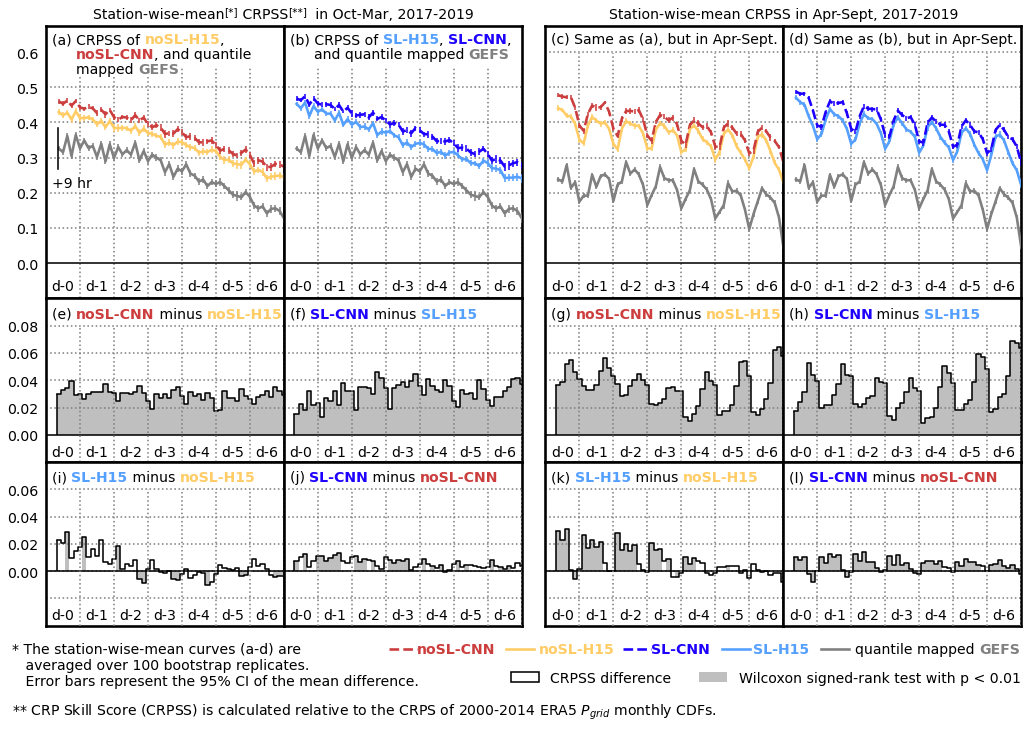

In [15]:
cates = ['rain', 'dry']
method_crps = ['base', 'bcnn', 'sl', 'scnn', 'gfs']

fig = plt.figure(figsize=(13, 8), dpi=dpi_)
gs = gridspec.GridSpec(3, 5, height_ratios=[1, 0.6, 0.6], width_ratios=[1, 1, 0.1, 1, 1])

ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[0, 1])
ax13 = plt.subplot(gs[1, 0])
ax14 = plt.subplot(gs[1, 1])
ax15 = plt.subplot(gs[2, 0])
ax16 = plt.subplot(gs[2, 1])

ax21 = plt.subplot(gs[0, 3])
ax22 = plt.subplot(gs[0, 4])
ax23 = plt.subplot(gs[1, 3])
ax24 = plt.subplot(gs[1, 4])
ax25 = plt.subplot(gs[2, 3])
ax26 = plt.subplot(gs[2, 4])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX_all = [ax11, ax12, ax13, ax14, ax15, ax16, ax21, ax22, ax23, ax24, ax25, ax26]
AX_crps = [ax11, ax12, ax21, ax22]
AX_diff_all = [ax13, ax14, ax15, ax16, ax23, ax24, ax25, ax26]
AX_diff_sub1 = [ax13, ax23]
AX_diff_sub2 = [ax14, ax24]
AX_diff_sub3 = [ax15, ax25]
AX_diff_sub4 = [ax16, ax26]

x_start1, y_start1 = 0.025, 0.975
x_start2, y_start2 = 0.025, 0.95
x_start3, y_start3 = 0.025, 0.95
handles = []
ax_t1 = fig.add_axes([0, 1.0, (2/4.1), 0.031875])
ax_t1.set_axis_off()
handles.append(ax_t1.text(0.5, 1, 'Station-wise-mean    CRPSS      in Oct-Mar, 2017-2019', ha='center', va='top', 
               fontsize=fontsize, transform=ax_t1.transAxes))

handles.append(ax_t1.text(0.368+0.006, 0.999, '[*]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))
handles.append(ax_t1.text(0.510, 0.999, '[**]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))

ax_t2 = fig.add_axes([2.1/4.1, 1.0, (2/4.1), 0.031875])
ax_t2.set_axis_off()
handles.append(ax_t2.text(0.5, 1, 'Station-wise-mean CRPSS in Apr-Sept, 2017-2019', ha='center', va='top', 
               fontsize=fontsize, transform=ax_t2.transAxes))

handles += gu.string_partial_format(fig, ax11, x_start1, y_start1, 'left', 'top', 
                                    ['(a) CRPSS of ', 'noSL-H15', ','], 
                                    ['k', orange, 'k'], [fontsize,]*3,  ['normal', 'bold', 'normal'])
handles += gu.string_partial_format(fig, ax11, x_start1+0.1, y_start1-0.055, 'left', 'top', 
                                    ['noSL-CNN', ', and quantile'], [red, 'k'], [fontsize,]*2,  ['bold', 'normal'])
handles += gu.string_partial_format(fig, ax11, x_start1+0.1, y_start1-0.11, 'left', 'top', 
                                    ['mapped ', 'GEFS',], ['k', gray, 'k'], [fontsize,]*3,  ['normal', 'bold', 'normal'])

handles += gu.string_partial_format(fig, ax12, x_start1, y_start1, 'left', 'top', 
                                    ['(b) CRPSS of ', 'SL-H15', ', ', 'SL-CNN', ','], 
                                    ['k', cyan, 'k', blue, 'k'], [fontsize,]*5,  ['normal', 'bold', 'normal', 'bold', 'normal'])
handles += gu.string_partial_format(fig, ax12, x_start1+0.1, y_start1-0.055, 'left', 'top', 
                                    ['and quantile mapped ', 'GEFS'], ['k', gray], [fontsize,]*2,  ['normal', 'bold'])

handles.append(ax21.text(x_start1, y_start1, '(c) Same as (a), but in Apr-Sept.', ha='left', va='top', 
                         fontsize=fontsize, transform=ax21.transAxes, zorder=6))

handles.append(ax22.text(x_start1, y_start1, '(d) Same as (b), but in Apr-Sept.', ha='left', va='top', 
                         fontsize=fontsize, transform=ax22.transAxes, zorder=6))

fontsize_list = [fontsize,]*5
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']

handles += gu.string_partial_format(fig, ax13, x_start2, y_start2, 'left', 'top', 
                                    ['(e) ', 'noSL-CNN', ' minus ', 'noSL-H15'], 
                                    ['k', red, 'k', orange, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax14, x_start2, y_start2, 'left', 'top', 
                                    ['(f) ', 'SL-CNN', ' minus ', 'SL-H15'], 
                                    ['k', blue, 'k', cyan, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax23, x_start2, y_start2, 'left', 'top', 
                                    ['(g) ', 'noSL-CNN', ' minus ', 'noSL-H15'], 
                                    ['k', red, 'k', orange, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax24, x_start2, y_start2, 'left', 'top', 
                                    ['(h) ', 'SL-CNN', ' minus ', 'SL-H15'], 
                                    ['k', blue, 'k', cyan, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax15, x_start3, y_start3, 'left', 'top', 
                                    ['(i) ', 'SL-H15', ' minus ', 'noSL-H15'], 
                                    ['k', cyan, 'k', orange, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax16, x_start3, y_start3, 'left', 'top', 
                                    ['(j) ', 'SL-CNN', ' minus ', 'noSL-CNN'], 
                                    ['k', blue, 'k', red, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax25, x_start3, y_start3, 'left', 'top', 
                                    ['(k) ', 'SL-H15', ' minus ', 'noSL-H15'], 
                                    ['k', cyan, 'k', orange, 'k'], fontsize_list, fontweight_list)
handles += gu.string_partial_format(fig, ax26, x_start3, y_start3, 'left', 'top', 
                                    ['(l) ', 'SL-CNN', ' minus ', 'noSL-CNN'], 
                                    ['k', blue, 'k', red, 'k'], fontsize_list, fontweight_list)

for ax in AX_all:
    ax = gu.ax_decorate_box(ax)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.set_xlim([0, 168])
    ax.set_xticks(np.arange(12, 168, 24))
    ax.axhline(0, xmin=0, xmax=1.0, linewidth=1.5, linestyle='-', color='k', zorder=3)
    
    for d in range(1, 8):
        ax.text(d/7.0-1/14, 0.02, 'd-{}'.format(int(d-1)), ha='center', va='bottom', 
                        fontsize=fontsize, transform=ax.transAxes, zorder=6)

for i, ax in enumerate(AX_crps):
    ax.set_ylim([-0.1, 0.675])
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    if i > 1:
        for y in np.arange(0.0, 0.7, 0.1):
            if np.abs(y-0)>0.01:
                ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5', zorder=2)
        for day in np.arange(24, 168+24, 24):
            ax.axvline(day, ymin=0, ymax=0.9, linewidth=1.5, linestyle=':', color='0.5', zorder=2)
    else:
        for y in np.arange(0.0, 0.6, 0.1):
            if np.abs(y-0)>0.01:
                ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5', zorder=2)
        for day in np.arange(24, 168+24, 24):
            ax.axvline(day, ymin=0, ymax=0.85, linewidth=1.5, linestyle=':', color='0.5', zorder=2)
            
for ax in AX_diff_sub1 + AX_diff_sub2:
    ax.set_ylim([-0.02, 0.1])
    ax.set_yticks([0.0, 0.02, 0.04, 0.06, 0.08,])
    for y in np.arange(0.02, 0.1, 0.02):
        ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5')
    for day in np.arange(24, 168+24, 24):
        ax.axvline(day, ymin=0, ymax=5/6, linewidth=1.5, linestyle=':', color='0.5', zorder=5)

for ax in AX_diff_sub3 + AX_diff_sub4:
    ax.set_ylim([-0.04, 0.08])
    ax.set_yticks([0.0, 0.02, 0.04, 0.06])
    for y in np.arange(-0.02, 0.08, 0.02):
        ax.axhline(y, xmin=0, xmax=1.0, linewidth=1.5, linestyle=':', color='0.5')
    for day in np.arange(24, 168+24, 24):
        ax.axvline(day, ymin=0, ymax=5/6, linewidth=1.5, linestyle=':', color='0.5', zorder=5)
        
ax11.tick_params(labelleft=True)
ax13.tick_params(labelleft=True)
ax15.tick_params(labelleft=True)

for i, key in enumerate(['base', 'bcnn', 'gfs']):
    AX_crps[0].errorbar(fcst_leads[:56], CRPS_MEAN['{}_rain'.format(key)], 
                        yerr=CRPS_STD['{}_rain'.format(key)], **KW[key], zorder=4)
    AX_crps[2].errorbar(fcst_leads[:56], CRPS_MEAN['{}_dry'.format(key)], 
                        yerr=CRPS_STD['{}_dry'.format(key)], **KW[key], zorder=4)
    
for i, key in enumerate(['sl', 'scnn', 'gfs']):
    AX_crps[1].errorbar(fcst_leads[:56], CRPS_MEAN['{}_rain'.format(key)], 
                        yerr=CRPS_STD['{}_rain'.format(key)], **KW[key], zorder=4)
    AX_crps[3].errorbar(fcst_leads[:56], CRPS_MEAN['{}_dry'.format(key)], 
                        yerr=CRPS_STD['{}_dry'.format(key)], **KW[key], zorder=4)
    
for i, key in enumerate(['rain', 'dry']):
    diff_ = CRPS_MEAN['bcnn_{}'.format(key)]-CRPS_MEAN['base_{}'.format(key)]
    AX_diff_sub1[i].bar(fcst_leads[:56], diff_, **kw_bar, zorder=2)
    AX_diff_sub1[i].step(fcst_leads[:56], diff_, **kw_step, zorder=4)
    AX_diff_sub1[i].vlines(fcst_leads[2]-1.5, ymin=0.0, ymax=diff_[2], color='k', linestyle='-', linewidth=1.5, zorder=5)
    
    diff_ = CRPS_MEAN['scnn_{}'.format(key)]-CRPS_MEAN['sl_{}'.format(key)]
    AX_diff_sub2[i].bar(fcst_leads[:56], diff_, **kw_bar, zorder=2)
    AX_diff_sub2[i].step(fcst_leads[:56], diff_, **kw_step, zorder=4)
    AX_diff_sub2[i].vlines(fcst_leads[2]-1.5, ymin=0.0, ymax=diff_[2], color='k', linestyle='-', linewidth=1.5, zorder=5)
    
    diff_ = np.copy(CRPS_MEAN['sl_{}'.format(key)]-CRPS_MEAN['base_{}'.format(key)])
    AX_diff_sub3[i].step(fcst_leads[:56], diff_, **kw_step, zorder=4)
    AX_diff_sub3[i].vlines(fcst_leads[2]-1.5, ymin=0.0, ymax=diff_[2], color='k', linestyle='-', linewidth=1.5, zorder=5)
    diff_[CRPS_wilcox['BASE_SL_{}'.format(key)] > 0.01] = np.nan
    AX_diff_sub3[i].bar(fcst_leads[:56], diff_, **kw_bar, zorder=2)
    
    diff_ = np.copy(CRPS_MEAN['scnn_{}'.format(key)]-CRPS_MEAN['bcnn_{}'.format(key)])
    AX_diff_sub4[i].step(fcst_leads[:56], diff_, **kw_step, zorder=4)
    AX_diff_sub4[i].vlines(fcst_leads[2]-1.5, ymin=0.0, ymax=diff_[2], color='k', linestyle='-', linewidth=1.5, zorder=5)
    diff_[CRPS_wilcox['BCNN_SCNN_{}'.format(key)] > 0.01] = np.nan
    AX_diff_sub4[i].bar(fcst_leads[:56], diff_, **kw_bar, zorder=2)
    
ax11.axvline(fcst_leads[2]-0.75, ymin=0.475, ymax=0.625, color='k', linestyle='-', linewidth=1.5, zorder=5)
handles.append(ax11.text(0.025, 0.45, '+9 hr', ha='left', va='top', fontsize=fontsize, transform=ax11.transAxes))

ax_w1 = fig.add_axes([-0.035, -0.1/1.2/8*10.2, 0.275, 0.075/1.2/8*10.2])
ax_w1.set_axis_off()
ax_w1.text(0, 1, '* The station-wise-mean curves (a-d) are\n   averaged over 100 bootstrap replicates.\n   Error bars represent the 95% CI of the mean difference.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([-0.035, -0.145/1.2/8*10.2, 0.5, 0.025/1.2/8*10.2])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '** CRP Skill Score (CRPSS) is calculated relative to the CRPS of 2000-2014 ERA5 $P_{grid}$ monthly CDFs.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w2.transAxes);

label_ = ['           ',
          '           ',
          '       ',
          '       ',
          '                                 ',]

handle_lines = []
handle_lines.append(mlines.Line2D([], [], label=label_[0], **kw_lines['bcnn']))
handle_lines.append(mlines.Line2D([], [], label=label_[1], **kw_lines['base']))
handle_lines.append(mlines.Line2D([], [], label=label_[2], **kw_lines['scnn']))
handle_lines.append(mlines.Line2D([], [], label=label_[3], **kw_lines['sl']))
handle_lines.append(mlines.Line2D([], [], label=label_[4], **kw_lines['gfs']))

ax_lg1 = fig.add_axes([0, -0.075/1.2/8*10.2, 1.0, 0.05/1.2/8*10.2])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=handle_lines, bbox_to_anchor=(1, 0.75), ncol=6, loc=7, prop={'size':fontsize}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

ax_lg1.text(0.3+0.08, 1, 'noSL-CNN', ha='left', va='top', fontsize=fontsize, fontweight='bold', 
            color=KW['bcnn']['color'], transform=ax_lg1.transAxes)
ax_lg1.text(0.3+0.205, 1, 'noSL-H15', ha='left', va='top', fontsize=fontsize, fontweight='bold', 
            color=KW['base']['color'], transform=ax_lg1.transAxes)

ax_lg1.text(0.3+0.32, 1, 'SL-CNN', ha='left', va='top', fontsize=fontsize, fontweight='bold', 
            color=KW['scnn']['color'], transform=ax_lg1.transAxes)
ax_lg1.text(0.3+0.425, 1, 'SL-H15', ha='left', va='top', fontsize=fontsize, fontweight='bold', 
            color=KW['sl']['color'], transform=ax_lg1.transAxes)

gu.string_partial_format(fig, ax_lg1, 0.325+0.505, 1, 'left', 'top', ['quantile mapped ', 'GEFS'], 
                         ['k', gray, 'k'], [fontsize,]*3,  ['normal', 'bold', 'normal']);

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor='none', edgecolor='k', linewidth=1.5,
                                    label='CRPSS difference'))
handle_legneds.append(patches.Patch(facecolor=kw_bar['color'], edgecolor='none', 
                                    label='Wilcoxon signed-rank test with p < 0.01'))

ax_lg2 = fig.add_axes([1.9/4.1, -0.0975/1.2/8*10.2, 2.2/4.1, 0.03/1.2/8*10.2])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend(handles=handle_legneds, bbox_to_anchor=(0.0, 0.5), ncol=2, loc=6, 
                    prop={'size':fontsize}, fancybox=False);
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)

for handle in handles:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_CRPS.png', format='png', **fig_keys)